In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<h1 style="color:#FF6F61;">Question 2.1: Multinomial Naive Bayes</h1>

In [48]:
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv', header=None)

y_train.columns = ['label']

print(x_train.shape)
print(y_train.shape)

(2300, 3000)
(2300, 1)


In [49]:
x_test = pd.read_csv('x_test.csv')
y_test = pd.read_csv('y_test.csv', header=None)

y_test.columns = ['label']

print(x_test.shape)
print(y_test.shape)

(700, 3000)
(700, 1)


In [50]:
review_label = {0:'negative', 1:'neutral', 2:'positive'}
categorized_train = y_train['label'].map(review_label)

train_reviews = categorized_train.value_counts()

train_reviews = train_reviews.to_dict()

print(train_reviews)

categorized_test = y_test['label'].map(review_label)

test_reviews = categorized_test.value_counts()

test_reviews = test_reviews.to_dict()

print(test_reviews)

{'positive': 849, 'neutral': 762, 'negative': 689}
{'positive': 251, 'neutral': 238, 'negative': 211}


Text(0.5, 1.0, 'Test Data')

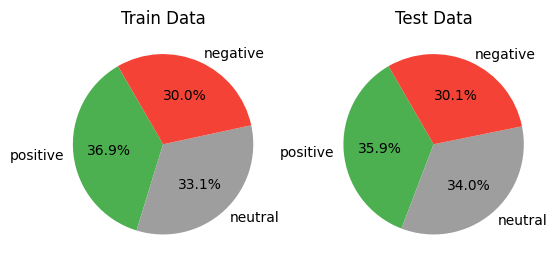

In [51]:
labels = train_reviews.keys()
train_counts = train_reviews.values()
test_counts = test_reviews.values()
colors = ['#4CAF50', '#9E9E9E', '#F44336']
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(train_counts, labels=labels, autopct='%1.1f%%', startangle=120, colors=colors)
ax2.pie(test_counts, labels=labels, autopct='%1.1f%%', startangle=120, colors=colors)

ax1.set_title('Train Data')
ax2.set_title('Test Data')

<h3 style="color:blue">Question 2.1.1</h4>


In [52]:
positive_indices = y_train[y_train['label'] == 2].index
num_of_good = 0
for index in positive_indices:
    num_of_good += x_train.loc[index]['good']

P_good = num_of_good/len(positive_indices)
print(np.log(P_good))

-1.4113403930459782


In [53]:
positive_indices = y_train[y_train['label'] == 2].index
num_of_bad = 0
for index in positive_indices:
    num_of_bad += x_train.loc[index]['bad']


P_bad = num_of_bad/len(positive_indices)
print(np.log(P_bad))

-4.259152536523347


<h1 style="color:#FF6F61;">Question 2.2: Multinomial Naive Bayes</h1>

In [54]:
x_train_matrix = np.matrix(x_train)
x_test_matrix = np.matrix(x_test)
y_train_matrix = np.matrix(y_train)
y_test_matrix = np.matrix(y_test)

x_transpose = x_train_matrix.T

In [55]:
#function that finds the thetas for each word of given class, log[P(Xj | Y = yk)]
def log_theta_calc(review_type):
    review_matrix = np.matrix(np.zeros((y_train.shape[0], 1)))
    review_indices = np.where(y_train_matrix == review_type)[0]
    review_matrix[review_indices] = 1
    column = x_transpose @ review_matrix
    column = column / column.sum()
    column = np.log(column)
    column[column == -np.inf] = -10**12
    return column

In [56]:
log_theta_matrix = np.zeros((len(x_test.columns), 3))
for k in range(3):
    review_k_column = log_theta_calc(k)
    log_theta_matrix[:, k] = review_k_column.ravel()

print(log_theta_matrix)

[[-8.55101474e+00 -1.00000000e+12 -9.62032857e+00]
 [-7.45240245e+00 -7.29720392e+00 -6.72995681e+00]
 [-8.04018912e+00 -9.08896339e+00 -9.62032857e+00]
 ...
 [-1.00000000e+12 -1.00000000e+12 -1.00000000e+12]
 [-8.95647985e+00 -8.39581621e+00 -9.62032857e+00]
 [-9.64962703e+00 -9.08896339e+00 -1.00000000e+12]]


<ipython-input-55-e3945c576004>:8: RuntimeWarning: divide by zero encountered in log
  column = np.log(column)


In [57]:
predictions = []

π = np.log(y_train.value_counts()/y_train.shape[0])
π[np.isneginf(π)] = -10**12

for row in x_test_matrix:
    y_values = []
    for k in range(3):
        y = π[k]
        y += row @ log_theta_matrix[:, k]
        y_values.append(y)

    classification = np.argmax(y_values)
    predictions.append(classification)

predictions_df = pd.DataFrame(predictions, columns=["predictions"])

print(predictions_df)

     predictions
0              2
1              2
2              0
3              2
4              0
..           ...
695            0
696            1
697            0
698            1
699            2

[700 rows x 1 columns]


In [58]:
predictions_and_reals = predictions_df.merge(y_test, left_index=True, right_index=True)
corrects = (predictions_and_reals['predictions'] == predictions_and_reals['label']).sum()
accuracy = (corrects / len(y_test)) * 100
print(f"Accuracy: {accuracy:.3f}%")

Accuracy: 58.143%


In [59]:
confusion_matrix = []
for i in range(3):
    count_list = []
    for label in range(3):
        matching_rows = predictions_and_reals[(predictions_and_reals['predictions'] == i) & (predictions_and_reals['label'] == label)]
        count = len(matching_rows)
        count_list.append(count)
    confusion_matrix.append(count_list)
confusion_matrix

[[138, 76, 32], [41, 78, 28], [32, 84, 191]]

<h1 style="color:#FF6F61;">Question 2.3: Multinomial Naive Bayes using a fair Dirichlet prior.</h1>
Same code just little bit difference in theta calculation


In [60]:
#function that finds the thetas for each word of given class, log[P(Xj | Y = yk)] with addding alfa=1 for each word
def log_theta_calc_dirichlet(review_type):
    review_matrix = np.matrix(np.zeros((y_train.shape[0], 1)))
    review_indices = np.where(y_train_matrix == review_type)[0]
    review_matrix[review_indices] = 1
    column = x_transpose @ review_matrix
    column = (column + 1) / (column.sum() + x_train_matrix.shape[1])
    column = np.log(column)
    column[column == -np.inf] = -10**12
    return column

In [61]:
log_theta_matrix_dirichlet = np.zeros((len(x_test.columns), 3))
for k in range(3):
    review_k_column = log_theta_calc_dirichlet(k)
    log_theta_matrix_dirichlet[:, k] = review_k_column.ravel()

print(log_theta_matrix_dirichlet)

[[-8.44009614 -9.38067369 -9.10875052]
 [-7.52380541 -7.43476354 -6.85745872]
 [-8.03463103 -8.68752651 -9.10875052]
 ...
 [-9.8263905  -9.38067369 -9.8018977 ]
 [-8.72777821 -8.2820614  -9.10875052]
 [-9.13324332 -8.68752651 -9.8018977 ]]


In [62]:
predictions_dirichlet = []

π = np.log(y_train.value_counts()/y_train.shape[0])
π[np.isneginf(π)] = -10**12

for row in x_test_matrix:
    y_values = []
    for k in range(3):
        y = π[k]
        y += row @ log_theta_matrix_dirichlet[:, k]
        y_values.append(y)

    classification = np.argmax(y_values)
    predictions_dirichlet.append(classification)

predictions_dirichlet_df = pd.DataFrame(predictions_dirichlet, columns=["predictions"])

print(predictions_dirichlet_df)

     predictions
0              2
1              2
2              0
3              2
4              0
..           ...
695            0
696            2
697            0
698            1
699            2

[700 rows x 1 columns]


In [63]:
predictions_and_reals_dirichlet = predictions_dirichlet_df.merge(y_test, left_index=True, right_index=True)
corrects_dirichlet = (predictions_and_reals_dirichlet['predictions'] == predictions_and_reals_dirichlet['label']).sum()
accuracy_dirichlet = (corrects_dirichlet / len(y_test)) * 100
print(f"Accuracy: {accuracy_dirichlet:.3f}%")

Accuracy: 64.857%


In [64]:
confusion_matrix = []
for i in range(3):
    count_list = []
    for label in range(3):
        matching_rows = predictions_and_reals_dirichlet[(predictions_and_reals_dirichlet['predictions'] == i) & (predictions_and_reals_dirichlet['label'] == label)]
        count = len(matching_rows)
        count_list.append(count)
    confusion_matrix.append(count_list)
confusion_matrix

[[151, 73, 13], [45, 86, 21], [15, 79, 217]]

<h1 style="color:#FF6F61;">Question 2.4: Bernoulli Naive Bayes</h1>

In [65]:
#function that turns to matrix into bernoulli matrix and finds the thetas for each word of given class, [P(Xj | Y = yk)]
def theta_bernoulli(review_type):
    transformed_matrix = np.where(x_train == 0, 0, 1)
    bernoulli_matrix_T = transformed_matrix.T
    review_matrix = np.matrix(np.zeros((y_train.shape[0], 1)))
    review_indices = np.where(y_train_matrix == review_type)[0]
    review_matrix[review_indices] = 1
    column = bernoulli_matrix_T @ review_matrix
    column += 1
    column = column / (y_train.value_counts().get(review_type) + 2)
    return column

In [66]:
predictions_bernoulli = []

π = np.log(y_train.value_counts()/y_train.shape[0])
π[np.isneginf(π)] = -10**12


theta_0 = theta_bernoulli(0)
theta_1 = theta_bernoulli(1)
theta_2 = theta_bernoulli(2)
thetas = [theta_0, theta_1, theta_2]

print(theta_0)

for row in x_test_matrix:
    y_values = []
    for k in range(3):
        y = π[k]
        theta = thetas[k]
        log_prob_present = np.log(theta)
        log_prob_absent = np.log(1 - theta)

        log_likelihood = np.sum(row * log_prob_present + (1 - row) * log_prob_absent)
        y_values.append(y + log_likelihood)

    classification = np.argmax(y_values)
    predictions_bernoulli.append(classification)

predictions_bernoulli_df = pd.DataFrame(predictions_bernoulli, columns=["predictions"])

print(predictions_bernoulli_df)


[[0.00578871]
 [0.01447178]
 [0.00868307]
 ...
 [0.00144718]
 [0.00434153]
 [0.00289436]]
     predictions
0              2
1              2
2              0
3              2
4              0
..           ...
695            0
696            2
697            1
698            1
699            1

[700 rows x 1 columns]


In [67]:
bernoulli_merged = predictions_bernoulli_df.merge(y_test, left_index=True, right_index=True)
corrects = (bernoulli_merged['predictions'] == bernoulli_merged['label']).sum()
accuracy = (corrects / len(y_test)) * 100
print(f"Accuracy: {accuracy:.3f}%")

Accuracy: 65.143%


In [68]:
confusion_matrix = []
for i in range(3):
    count_list = []
    for label in range(3):
        matching_rows = bernoulli_merged[(bernoulli_merged['predictions'] == i) & (bernoulli_merged['label'] == label)]
        count = len(matching_rows)
        count_list.append(count)
    confusion_matrix.append(count_list)
confusion_matrix

[[122, 33, 19], [82, 174, 72], [7, 31, 160]]